In [3]:
import os

# Model
%env CUDA_VISIBLE_DEVICES=3,2
#%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:32

# HF Cache
os.environ["HF_HOME"] = "../.cache"
!echo $HF_HOME
!huggingface-cli whoami

env: CUDA_VISIBLE_DEVICES=3,2
../.cache


TorgeSchwark
orgs:  Basket-AEye


Using cache found in /home/stu236894/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/stu236894/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Image shape: (256, 251, 4)
Prediction shape: torch.Size([1, 384, 384])
Depth map shape: (384, 384)


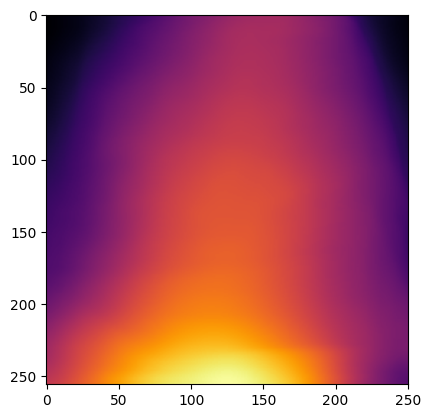

In [7]:
import cv2
import os
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Laden des vortrainierten MiDaS-Modells

model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

# 'midas = torch.hub.load("intel-isl/MiDaS", model_type)'

model = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")  # MiDaS Small für schnellere Verarbeitung
model.eval()

# Laden der Bilddatei
image_path = '/data22/stu236894/GitRepos/TinyML-MT/huggingface/ai_shelf/sd/10classes_without_background/fruit tea/fruit tea_fruit tea1_bottom_2_no_background.png'  # Dein Bildpfad

if not os.path.exists(image_path):
    print(f"Error: {image_path} does not exist!")
else:
    # Bild mit PIL laden
    image = Image.open(image_path)
    image = np.array(image)  # Konvertiere PIL-Bild zu NumPy Array für OpenCV und weitere Verarbeitung

    # Ausgabe der Bildform für Debugging
    print(f"Image shape: {image.shape}")

    # Bild für das Modell vorbereiten
    input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_image = cv2.resize(input_image, (384, 384))
    input_image = input_image / 255.0  # Normalisieren
    input_image = torch.from_numpy(input_image).unsqueeze(0).permute(0, 3, 1, 2).float()

    # Tiefenschätzung durchführen
    with torch.no_grad():
        prediction = model(input_image)

    # Sicherstellen, dass die Vorhersage korrekt ist
    print(f"Prediction shape: {prediction.shape}")

    # Tiefenkarten in Bildform konvertieren
    depth_map = prediction.squeeze().cpu().numpy()

    # Überprüfen, ob die Tiefenkarte gültig ist
    print(f"Depth map shape: {depth_map.shape}")

    # Visualisierung der Tiefenkarten
    depth_map = cv2.resize(depth_map, (image.shape[1], image.shape[0]))
    plt.imshow(depth_map, cmap='inferno')
    plt.show()


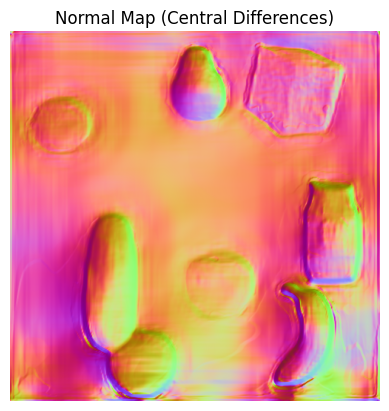

In [162]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_normals_from_depth_camera(depth):
    h, w = depth.shape
    normals = np.zeros((h, w, 3), dtype=np.float32)

    # Padding, um Randprobleme zu vermeiden
    padded = np.pad(depth, ((1, 1), (1, 1)), mode='edge')

    # Zentrale Differenzen zur Berechnung der Ableitungen
    dzdx = (padded[2:, 1:-1] - padded[0:-2, 1:-1]) / 2.0
    dzdy = (padded[1:-1, 2:] - padded[1:-1, 0:-2]) / 2.0

    # Normalen berechnen
    normals[..., 0] = -dzdx
    normals[..., 1] = -dzdy
    normals[..., 2] = 1.0

    # Normalisieren
    norm = np.linalg.norm(normals, axis=2, keepdims=True)
    normals /= (norm + 1e-8)

    return normals

# Beispielnutzung:
# depth_map = ... (z. B. ein Float32-Bild mit Depthwerten in Metern oder mm)
# depth_map muss vom Typ float32 sein
depth_map = depth_map.astype(np.float32)

normal_map = compute_normals_from_depth_camera(depth_map)

# In RGB umwandeln zur Visualisierung
normal_rgb = ((normal_map + 1) / 2 * 255).astype(np.uint8)

# Anzeigen
plt.imshow(cv2.cvtColor(normal_rgb, cv2.COLOR_BGR2RGB))
plt.title("Normal Map (Central Differences)")
plt.axis("off")
plt.show()


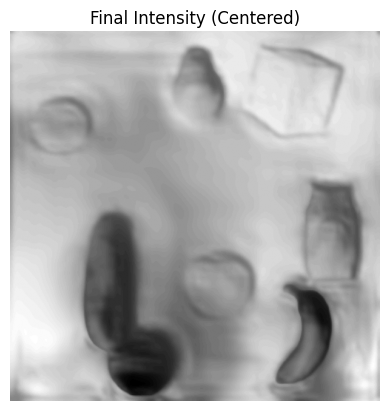

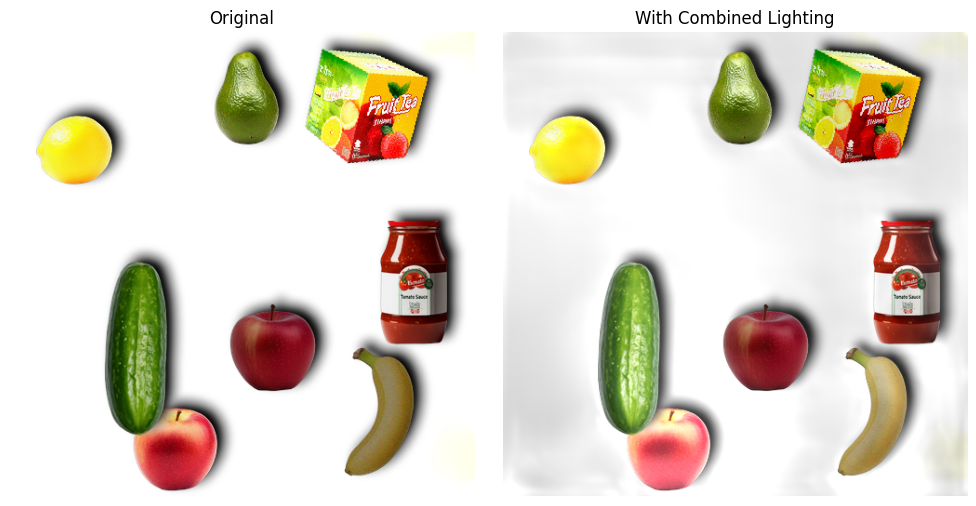

In [169]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

def apply_combined_lighting(image, normal_map, depth_map, light_direction=np.array([1, -1, 2]), depth_weight=0.5):
    # Normalize the light direction
    light_dir = light_direction / np.linalg.norm(light_direction)
    
    # Calculate the dot product of normals and light direction
    dot = np.clip(np.sum(normal_map * light_dir[None, None, :], axis=2), 0, 1)
    dot = cv2.GaussianBlur(dot, (15, 15), 0)  # Optional smoothing of the dot product

    # Normalize depth map to [0, 1] range
    depth_norm = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    
    # Adjust depth influence with the depth_weight parameter (weight depth effect)
    depth_light = (1.0 - depth_norm)*0.4
 # Start depth at 0.2 to avoid excessive darkening

    # Combine the normal-based lighting and depth-based lighting using the depth_weight factor
    final_intensity = np.clip(dot * ((1 - depth_weight)) + depth_light * depth_weight, 0, 1)

    # Calculate the mean value of final_intensity and center the intensity around this mean
    mean_intensity = np.mean(final_intensity)
    centered_intensity = final_intensity - mean_intensity  # Center the intensity around the mean

    # Handle image alpha (transparency) channel if it exists
    if image.shape[2] == 4:
        alpha = image[..., 3:]
        image = image[..., :3]
    else:
        alpha = None

    # Apply lighting to the color channels (brighter where centered_intensity > 0, darkening where < 0)
    lit_image = np.clip(image + (centered_intensity[..., None] * -255), 0, 255).astype(np.uint8)

    # Visualization of the final intensity
    final_intensity_display = ((centered_intensity + 1) * 127.5).astype(np.uint8)  # Display centered intensity

    # Anzeigen der final_intensity
    plt.imshow(final_intensity_display, cmap='gray')
    plt.title("Final Intensity (Centered)")
    plt.axis("off")
    plt.show()

    # Re-apply alpha if it exists
    if alpha is not None:
        lit_image = np.concatenate([lit_image, alpha], axis=2)

    return lit_image

# Beleuchtung anwenden
lit_image = apply_combined_lighting(image, normal_map, depth_map, depth_weight=0.8)  # Example with 0.7 for depth weighting

# Anzeigen
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(Image.fromarray(image))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("With Combined Lighting")
plt.imshow(Image.fromarray(lit_image))
plt.axis("off")
plt.tight_layout()
plt.show()


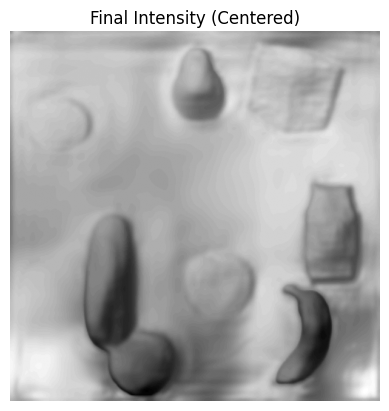

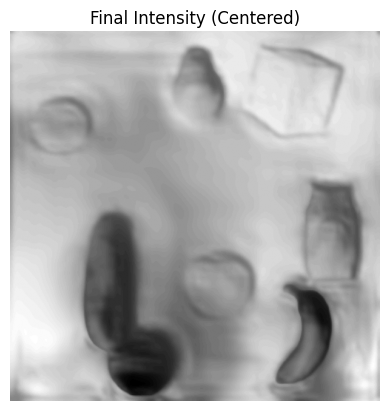

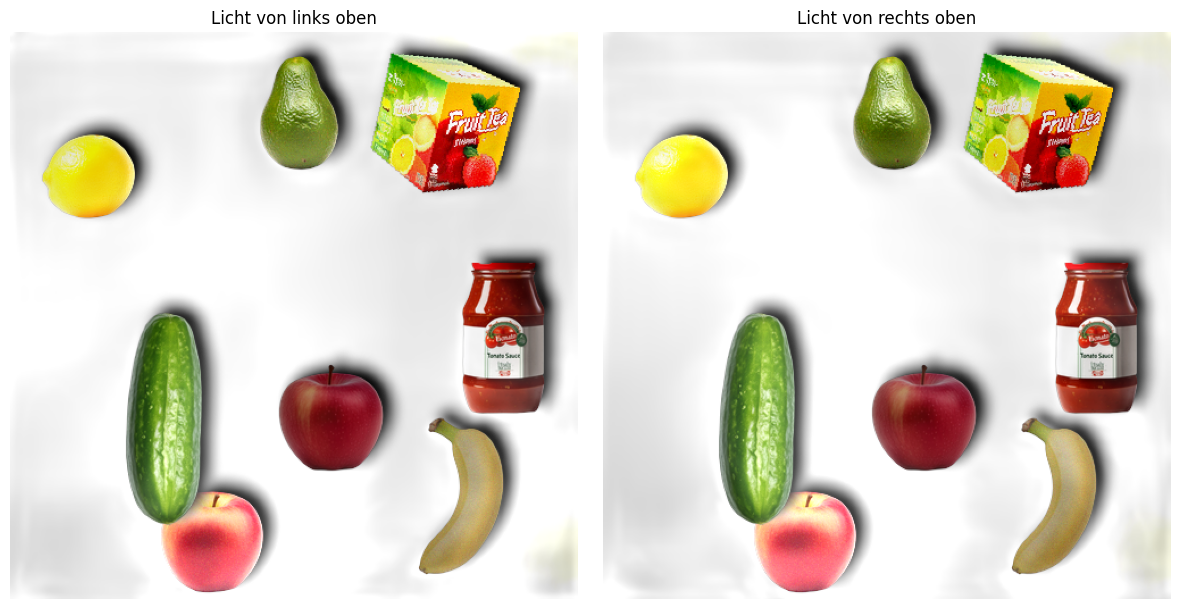

In [170]:
# Beispielhafte Lichtquellen aus verschiedenen Richtungen
light_dirs = [
    np.array([-1, -1, 2]),  # Licht von links oben
    np.array([1, -1, 2])    # Licht von rechts oben
]

# Zwei Bilder erzeugen
lit_images = []
for i, dir in enumerate(light_dirs):
    lit = apply_combined_lighting(image, normal_map, depth_map, light_direction=dir, depth_weight=0.8)
    lit_images.append(lit)

# Anzeigen der beiden Beleuchtungen
plt.figure(figsize=(12, 6))
titles = ["Licht von links oben", "Licht von rechts oben"]

for i, lit in enumerate(lit_images):
    plt.subplot(1, 2, i + 1)
    plt.title(titles[i])
    plt.imshow(Image.fromarray(lit))
    plt.axis("off")

plt.tight_layout()
plt.show()
